### Preamble


> ⚠️ **Warning:** This notebook file is paired to a .py file with the same name, such that we can cleanly import the functionality from other notebooks. This is done using the facilities of the jupytext package. The cells in this notebook that are only meant as "demonstration" are marked with the cell tag "active-ipynb", which causes the jupytext synchronization command to ignore these when syncing to the .py file. This is our current way of doing "literate programming" with jupyter notebooks.

In [1]:
import numpy as np
rng = np.random.default_rng(seed=70)

In [ ]:
%load_ext autoreload
%autoreload 2
%cd /home/jeroen/repos/traffic-scheduling/single

# Getting started

Table of contents:
- instances data class
- optimal schedules, using mixed-integer linear programming
- instance generation by sampling arrival sequences per route

## Instance data class

Let us first introduce a little utility class to keep everything related to an instance nice and organized. The `add_route_from_gaps()` method computes the arrival times $a_i$ from a list of "gaps" between the vehicles. This makes sure that $a_i + \rho \leq a_j$ is satisfied for each conjunctive pair.

The switch time `switch`, number of routes `R`, number of vehicles per route `n[r]`, total number of vehicles `N`, and the `vehicle_indices`, can all be derived from the specification of `arrivals`, `rho` and `sigma`.

Each instance can be visualized by calling `instance.visualize()`. Since we already implement empty/partial/full schedule visualization in the gym environment, we generate a dummy env, reset it and render with some default options. See `SingleEnvironment.visualize()` for the options available.

In [2]:
from single.mdp import SingleScheduleEnv
from dataclasses import dataclass

@dataclass
class SingleInstance:
    # allow dynamically adding of routes
    arrivals: list[np.ndarray] | None = None

    rho: float   = 1     # following time
    sigma: float = 1.5   # time between conflicting vehicles

    @property
    def switch(self): return self.sigma - self.rho
    @property
    def R(self): return len(self.arrivals)
    @property
    def n(self): return [len(self.arrivals[r]) for r in range(self.R)]
    @property
    def N(self): return sum(self.n)

    @property
    def vehicle_indices(self):
        """Get list of vehicle indices {(r, k)} from instance specification."""
        R = range(self.R); n = [range(self.n[r]) for r in R]
        # use 'sorted' to guarantee lexicographical order
        return sorted([(r, k) for r in R for k in n[r]])

    def visualize(self, **kwargs):
        """Utility function to visualize instance without having to construct MDP first."""
        # some sensible defaults
        options = {
            'dimmed_partial': False,
            'block_text': True,
            **kwargs
        }
        env = SingleScheduleEnv(instance=self, options=options)
        env.reset(); env.render()

    def add_route(self, lengths):
        """Add the arrivals of a new route."""
        if self.arrivals is None:
            self.arrivals = [lengths]
        else:
            self.arrivals.append(lengths)

    def add_route_from_gaps(self, gaps):
        """Compute $A_n = A_{n-1} + X_n + \rho$ for all n, where X_n is given by `gaps`."""
        lengths = np.repeat(self.rho, len(gaps))
        shifted = np.roll(lengths, 1); shifted[0] = 0
        arrivals = np.cumsum(gaps + shifted)
        self.add_route(arrivals)

## Optimal schedules (MILP)

### Simple data class for solutions

In [30]:
from dataclasses import dataclass

@dataclass
class SingleMILPSchedule:
    instance: SingleInstance
    y: list[np.ndarray]
    obj: float
    done: bool
    gap: float
    time: float

    @property
    def vehicle_order(self):
        """Compute $nu$."""
        ix = self.instance.vehicle_indices.copy()
        ix.sort(key=lambda i: self.y[i[0]][i[1]])
        return ix

    @property
    def route_order(self):
        """Compute $eta$."""
        return [r for r, k in self.vehicle_order]
    
    @property
    def delay(self):
        """Compute sum_{i in mathcal{N}} y_i - a_i"""
        return sum(y.sum() for y in self.y) - sum(a.sum() for a in self.instance.arrivals)

    def visualize(self, **kwargs):
        """Utility function to visualize schedule, backtracking the solution
        from the MILP schedule if necessary."""
        options = { 'block_text': True, **kwargs }
        env = SingleScheduleEnv(instance=self.instance, options=options)
        env.reset()
        [env.step(r) for r in self.route_order] # execute the schedule
        env.render()

### Mixed-integer linear programming

In [31]:
import gurobipy as gp
import numpy as np
from itertools import product, combinations
import os

def solve(instance, gap=0.0, timelimit=0, consolelog=False, logfile=None, cutting_planes=None):
    """Solve a single intersection scheduling problem as a MILP.

    `cutting_planes` is a list/set specifying which cutting planes to add,
    possible choices are integers:
        1 - transitive cutting planes
        2 - necessary conjunctive cutting planes
        3 - necessary disjunctive cutting planes
    """

    env = gp.Env(empty=True)
    if not consolelog:
        env.setParam('LogToConsole', 0)  # disable console logging
    if logfile is not None:
        env.setParam('LogFile', logfile)
        # make sure directory exists
        os.makedirs(os.path.dirname(os.path.abspath(logfile)), exist_ok=True)
    if timelimit > 0:
        env.setParam('TimeLimit', timelimit)

    env.start()
    g = gp.Model(env=env)

    if cutting_planes is None:
        cutting_planes = []

    arrivals = instance.arrivals    # earliest crossing times (a_i)
    rho = instance.rho            # vehicle follow time (rho)
    sigma = instance.sigma        # time between conflicts (sigma)

    R = len(arrivals) # number of routes
    n = [len(r) for r in arrivals] # number of arrivals per route

    # big-M
    M = 1000

    ### Variables

    # non-negative starting times
    y = {}
    for r in range(R):
        for k in range(n[r]):
            y[r, k] = g.addVar(obj=1, vtype=gp.GRB.CONTINUOUS, name=f"y_{r}_{k}")
            g.addConstr(y[r, k] >= arrivals[r][k])

    ### Constraints

    # indicator variables for the necessary cutting planes
    delta = {}

    # conjunctions
    for r in range(R):
        for k in range(n[r] - 1):
            g.addConstr(y[r, k] + rho <= y[r, k + 1])

            # definition of delta
            if 2 in cutting_planes or 3 in cutting_planes:
                delta[r, k] = g.addVar(obj=0, vtype=gp.GRB.BINARY, name=f"delta_{r}_{k}")
                g.addConstr(y[r, k] + rho <= arrivals[r][k + 1] + delta[r, k] * M)
                g.addConstr(y[r, k] + rho >= arrivals[r][k + 1] - (1 - delta[r, k]) * M)

            if 2 in cutting_planes:
                g.addConstr(y[r, k] + rho >= y[r, k + 1] - (1 - delta[r, k]) * M)


    # disjunctions
    o = {}
    for r1, r2 in combinations(range(R), 2):
        for k, l in product(range(n[r1]), range(n[r2])):
            oc = g.addVar(obj=0, vtype=gp.GRB.BINARY, name=f"o_{r1}_{k}_{r2}_{l}")
            o[r1, k, r2, l] = oc

            g.addConstr(y[r1, k] + sigma <= y[r2, l] + oc * M)
            g.addConstr(y[r2, l] + sigma <= y[r1, k] + (1 - oc) * M)

            # transitive cutting planes
            if 1 in cutting_planes:
                g.addConstr(gp.quicksum(o[r1, p, r2, q] for p in range(0, k) for q in range(l + 1, n[r2])) <= o[r1, k, r2, l] * M)


    # necessary disjunctive cutting planes
    if 3 in cutting_planes:
        for r1, r2 in combinations(range(R), 2):
            for l in range(n[r1] - 1): # for all conjunctive pairs (i, j) = ((r1, l), (r1, l + 1))
                for k in range(n[r2]):
                    g.addConstr(delta[r1, l] + (1 - o[r1, l, r2, k]) + o[r1, l + 1, r2, k] <= 2)
                    g.addConstr(delta[r1, l] + o[r1, l, r2, k] + (1 - o[r1, l + 1, r2, k]) <= 2)

    ### Solving

    g.ModelSense = gp.GRB.MINIMIZE
    g.Params.MIPGap = gap
    g.update()
    g.optimize()

    res = { 'y': [], 'obj': g.getObjective().getValue() }
    y = { r : (v.X if hasattr(v, 'X') else v) for r, v in y.items() }
    for r in range(R):
        res['y'].append(np.array([y[r, j] for j in range(n[r])]))

    res['done'] = int(g.status == gp.GRB.OPTIMAL)
    res['gap'] = g.MIPGap
    res['time'] = g.Runtime

    return SingleMILPSchedule(instance=instance, **res)

Just keep this method at the instance class, for convenience.

In [32]:
def solve_myself(self, **kwargs): self.opt = solve(self, **kwargs)
SingleInstance.solve = solve_myself

## Instance generation

A problem instance of the crossing time scheduling problem is specified by the tuple
$$
(\mathcal{N}, a, \rho, \sigma) .
$$
Here, $\mathcal{N}$ is the set of vehicle indices, which depends on the route indices $\mathcal{R} = \{ 1, \dots, R \}$ and the number $n_r$ of vehicles per route, so that we have
$$
\mathcal{N} = \{ (i,j) : j \in \{ 1, \dots, n_r \}, i \in \mathcal{R} \} .
$$
The processing time $\rho$ and the switch-over time $\sigma$ are assumed to be fixed in our analysis.

In [6]:
rho, sigma = 1.2, 1.7 # so "switch" = sigma-rho

The most interesting part of the problem specification are the earliest arrival times $a_i : i \in \mathcal{N}$. Our hypothesis is that the way these are distributed influences the performance of the learned scheduling algorithm. Therefore, we propose some artificial distribution of arrival times based on the following  two aspects:

- same arrival intensity across routes (symmetric) vs. different intensities (assymetric),
- degree of platooning, or in other words, controlling the time gap between groups of vehicles.

A simple way of modeling the natural occurence of platoons in the arrival process is by using a bimodal distribution $F$ for the interarrival times. We will use a mixture of two exponential random variables with different means, representing the small gaps between vehicles in the same platoon and the large gaps between vehicles of different platoons.

In [7]:
def bimodal_exponential(p=0.3, s1=1, s2=10):
    def generate(n):
        ps = rng.binomial(1, p, size=(n))
        return ps * rng.exponential(scale=s1, size=(n)) + (1-ps) * rng.exponential(scale=s2, size=(n))
    return generate

def uniform(min=0, max=1):
    def generate(n):
        return rng.uniform(min, max, size=(n))
    return generate

For figures in the report, we also "clip" the value to 0, if the gap is below the given minimum value, which looks a little bit nicer: when the outer lines of the vehicle rectangles are very near each other, they make a thick black line of double width, which is ugly.
This is handled by the following wrapper function.

In [8]:
def clipped(generator, min=0.2):
    def generate(n):
        gaps = generator(n)
        gaps[gaps < min] = 0
        return gaps
    return generate

The following method generates simple symmetric instances when F is a single "gap-generator".
When F is a list of "gap-generators", one for each route, we generate an "assymetric" instance.
The number of arrivals per route (n) can be a single number (same number of arrivals for each route) or a list.
When the number of routes (R) cannot be derived from either F or n (which we can when they are lists), it needs to be explicitly specified.

In [9]:
from collections.abc import Iterable

def generate_instance(F, n=1, R=None, rho=1.2, sigma=1.7):
    """F is a (list of) "gap-generator" function(s) to generate the interarrival
    times. n is the number of arrivals per route
    (either single number or list). R is the number of routes, which needs to be
    specified explicitly if it cannot be derived from F or n. In other words,
    R and n are automatically 'broadcasted'."""
    assert sigma > rho, "This choice surely gives a valid combinatorial problem, but it makes no sense in the original problem context."
    instance = SingleInstance(rho=rho, sigma=sigma)

    R1 = len(F) if not callable(F) else None
    R2 = len(n) if isinstance(n, Iterable) else None
    if R1 is not None and R2 is not None:
        if R1 != R2:
            raise Exception(f"Number of gap-generators {R1} in F should match number of routes {R2} specified by n.")
        if R is not None and R != R1:
            raise Exception(f"Number of routes specified by F and n ({R1}) should match R={R}.")
    if R is None:
        R = R1 or R2
 
    for r in range(R):
        # make explicit singletons
        if not callable(F): f = F[r]
        else: f = F
        if isinstance(n, Iterable): n1 = n[r]
        else: n1 = n

        # create random interarrival times ("gaps") and cumulate them to obtain
        # earliest arrival times
        instance.add_route_from_gaps(f(n1))
    return instance

We define some dummy instance generator to produce small simple instances to use during development.

In [10]:
def generate_simple_instance(n=[3, 3]):
    return generate_instance(clipped(uniform()), n)

## Visualizing instances and schedules

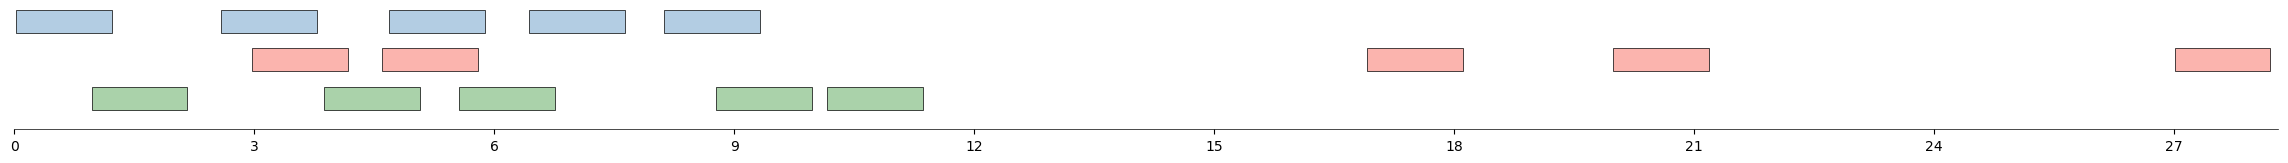

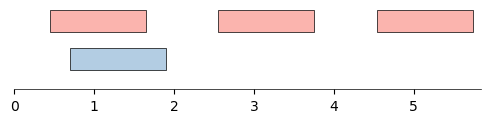

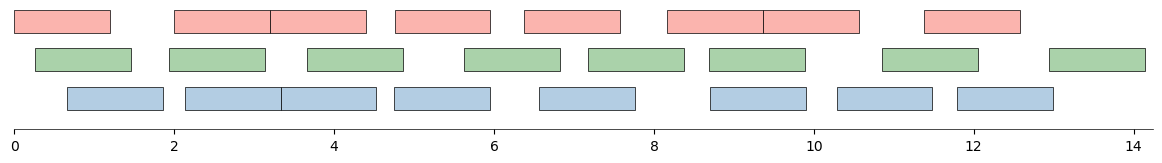

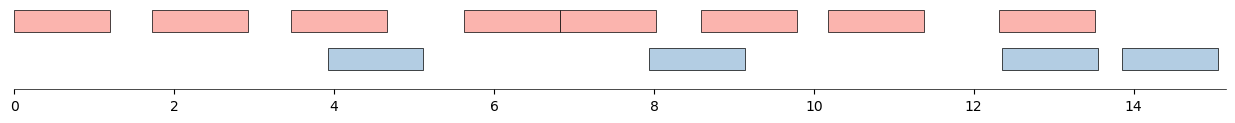

In [12]:
options = { 'block_text': False }

F = bimodal_exponential(p=0.2, s1=0.2, s2=2.0)
generate_instance(F, n=5, R=3).visualize(**options)
generate_instance(clipped(uniform()), n=[1, 3]).visualize(**options)
generate_instance(clipped(uniform()), n=8, R=3).visualize(**options)
generate_instance([clipped(uniform(0, 4)), clipped(uniform())], n=[4, 8]).visualize(**options)

Now visualize a complete schedule, by executing some random scheduling policy.

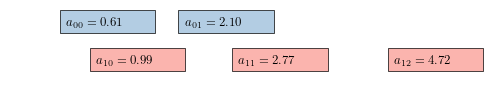

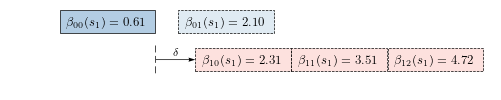

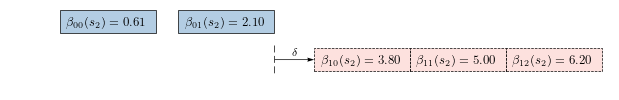

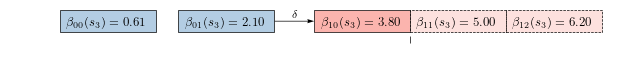

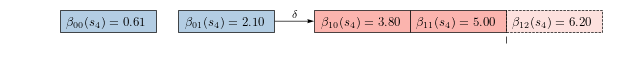

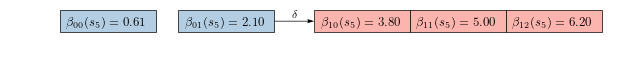

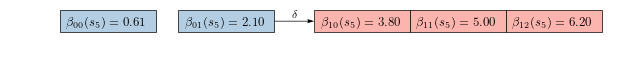

In [13]:
options = {
    'block_text': True,
    'no_axis': True,
    'tex': True,
}

self = generate_instance(clipped(uniform(0, 1)), R=2, n=[2,3])
env = SingleScheduleEnv(instance=self, options=options)
env.action_space.seed(11) # to keep the same example once we like it
obs, info = env.reset()

self.visualize(out='figures/instance.pdf', **options)

# obtain some random schedule
done = False
while not done:
    # mask = valid actions = routes with unscheduled vehicles
    mask = (~obs['done']).astype(np.int8)
    action = env.action_space.sample(mask)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

# draw the final schedule
env.options['out'] = 'figures/schedule.pdf'
env.render()

## Testing the MILP and MDP implementation

In [36]:
instance = SingleInstance(
    arrivals=[np.array([1, 2, 4]), np.array([1, 2.5])],
    rho=1, sigma=3
)

instance.solve()

print(instance.opt.delay)
instance, instance.opt

11.5


(SingleInstance(arrivals=[array([1, 2, 4]), array([1. , 2.5])], rho=1, sigma=3),
 SingleMILPSchedule(instance=SingleInstance(arrivals=[array([1, 2, 4]), array([1. , 2.5])], rho=1, sigma=3), y=[array([1., 2., 4.]), array([7., 8.])], obj=22.0, done=1, gap=0.0, time=0.0015079975128173828))

-11.5


array([[1., 2., 4.],
       [7., 8., 0.]])

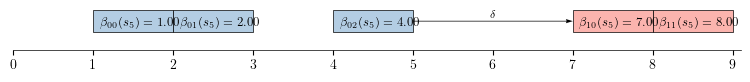

In [ ]:
from single.mdp import SingleScheduleEnv

env = SingleScheduleEnv(instance=instance)

obs, info = env.reset()
total_reward = 0
for r in instance.opt.route_order:
    _, reward, *_ = env.step(r)
    total_reward += reward

env.render()
print(total_reward)
env.LB